In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/malicious_phishing_.csv')

In [ ]:
df["category"] = df["type"].replace({
    'legitimate': 1,
    'phishing': 0,
})

In [ ]:
def url_length(url):
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    suffixes = ['.html', '.php', '.pdf']
    for suffix in suffixes:
        url = url.replace(suffix, '')

    return len(url)

In [ ]:
df['URL Length'] = df['url'].apply(url_length)
df['Letters Count'] = df['url'].apply(lambda x: sum(char.isalpha() for char in x))
df['Digits Count'] = df['url'].apply(lambda x: sum(char.isdigit() for char in x))
df['Special Chars Count'] = df['url'].apply(lambda x: sum(char in string.punctuation for char in x))

In [ ]:
class URLAnalyzer:
    def subdomains(self, url):
        subdomains = url.split('://')[-1].split('/')[0].split('.')
        return max(len(subdomains) - 2, 0)

    def entropy(self, url):
        string = url.strip()
        prob = [float(string.count(c)) / len(string) for c in set(string)]
        entropy = -sum([(p * np.log2(p)) for p in prob if p != 0])
        return entropy

In [ ]:
analyzer = URLAnalyzer()
df['SubDomain'] = df['url'].apply(analyzer.subdomains)
df['Entropy'] = df['url'].apply(analyzer.entropy)

In [ ]:
def have_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass

    return 0

In [ ]:
df['Have IP Address'] = df['url'].apply(have_ip_address)

In [ ]:
def check_port(url):
    port_start = url.find(':')

    if port_start != -1:
        port_str = url[port_start + 1:].split('/')[0]

        try:
            port = int(port_str)
            if port in {21, 70, 80, 443, 1080, 8080}:
                return 1
            else:
                return 0
        except ValueError:
            return 0
    else:
        return 0

In [ ]:
df['port'] = df['url'].apply(check_port)

In [ ]:
df.to_csv('/content/drive/MyDrive/dataset/pretrained_data.csv', index=False)

In [ ]:
data = df.drop(columns=['type', 'url'])

In [ ]:
data.to_csv('/content/drive/MyDrive/dataset/pretrained_data_2.csv', index=False)

In [ ]:
x = data.drop(columns=['category'])
y = data['category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

x_train_array = x_train.values.astype(np.float32)
x_test_array = x_test.values.astype(np.float32)

y_train_array = y_train.values.astype(np.float32)
y_test_array = y_test.values.astype(np.float32)

In [ ]:
print(f"X_train Shape : {x_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {x_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (126554, 8)
Y_train Shape : (126554,)
X_test  Shape : (54238, 8)
Y_test  Shape : (54238,)


In [ ]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Reshape((8, 1), input_shape=(8, )),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),
    tf.keras.layers.Conv1D(32, kernel_size=1, activation='relu'),  # Reduced kernel size
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_cnn.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 8, 1)              0         
                                                                 
 conv1d_10 (Conv1D)          (None, 6, 64)             256       
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 3, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 3, 32)             2080      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 64)               

In [ ]:
history_cnn = model_cnn.fit(x_train_array, y_train_array, epochs=50, batch_size=128, validation_data=(x_test_array, y_test_array))

Epoch 1/50
989/989 [==============================] - 7s 5ms/step - loss: 0.4755 - accuracy: 0.7862 - val_loss: 0.4096 - val_accuracy: 0.8215
Epoch 2/50
989/989 [==============================] - 5s 5ms/step - loss: 0.3928 - accuracy: 0.8330 - val_loss: 0.3648 - val_accuracy: 0.8414
Epoch 3/50
989/989 [==============================] - 9s 9ms/step - loss: 0.3752 - accuracy: 0.8385 - val_loss: 0.3425 - val_accuracy: 0.8538
Epoch 4/50
989/989 [==============================] - 7s 7ms/step - loss: 0.3656 - accuracy: 0.8422 - val_loss: 0.3553 - val_accuracy: 0.8445
Epoch 5/50
989/989 [==============================] - 7s 7ms/step - loss: 0.3595 - accuracy: 0.8470 - val_loss: 0.3628 - val_accuracy: 0.8382
Epoch 6/50
989/989 [==============================] - 5s 5ms/step - loss: 0.3533 - accuracy: 0.8505 - val_loss: 0.3320 - val_accuracy: 0.8616
Epoch 7/50
989/989 [==============================] - 5s 5ms/step - loss: 0.3504 - accuracy: 0.8532 - val_loss: 0.3473 - val_accuracy: 0.8480
Epoch 

In [ ]:
model_cnn.save('/content/drive/MyDrive/dataset/Models/pretrained_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
evaluation_results = model_cnn.evaluate(x_test_array, y_test_array)

loss, accuracy = evaluation_results

print(f'Loss on test set: {loss:.4f}')
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

1695/1695 [==============================] - 6s 4ms/step - loss: 0.3159 - accuracy: 0.8657
Loss on test set: 0.3159
Accuracy on test set: 86.57%


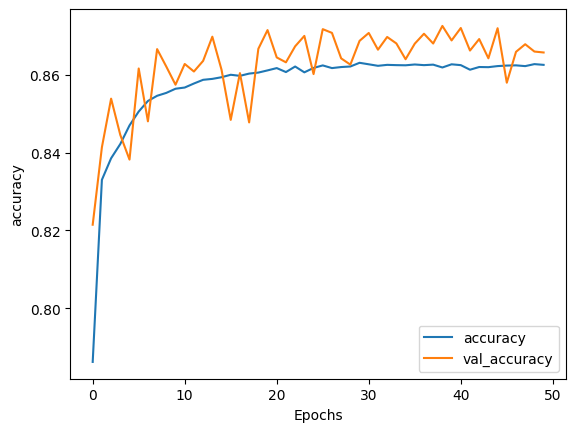

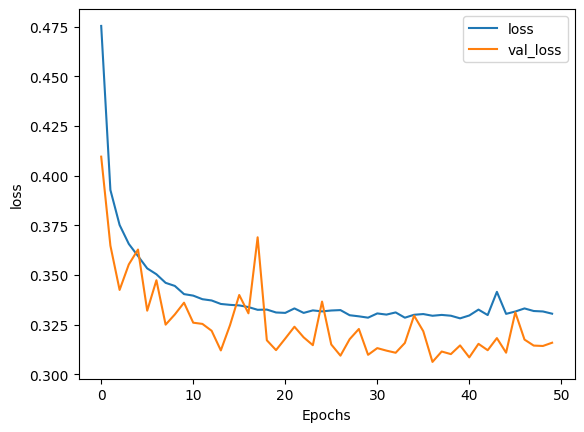

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history[f'val_{string}'])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, f'val_{string}'])
    plt.show()

plot_graphs(history_cnn, 'accuracy')
plot_graphs(history_cnn, 'loss')